**Predicción de radiación solar a partir de imágenes satelitales 2022**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import r2_score, mean_squared_error
# !pip install xgboost
from xgboost import XGBRegressor
from sklearn import svm, tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold
from scipy.stats import loguniform

pd.set_option('display.precision', 4)
%matplotlib inline

**Cargar y combinar datasets con datos obtenidos de las imágenes**

In [2]:
df_acmocoa_2012 = pd.read_csv('../Investigación Doctoral en Ingeniería III/data/DS-ACMocoa-2012.csv', sep=';')
df_acmocoa_2013 = pd.read_csv('../Investigación Doctoral en Ingeniería III/data/DS-ACMocoa-2013.csv', sep=';')
df_acmocoa_2014 = pd.read_csv('../Investigación Doctoral en Ingeniería III/data/DS-ACMocoa-2014.csv', sep=';')
df_acmocoa = pd.concat([df_acmocoa_2012, df_acmocoa_2013, df_acmocoa_2014], ignore_index=True, sort=False)
df_acmocoa.insert(0, 'Estacion', 'ACMocoa', allow_duplicates=False)
df_acmocoa = df_acmocoa.drop(df_acmocoa[(df_acmocoa['RadSolar'] <= 0)].index)

df_el_pepino_2012 = pd.read_csv('../Investigación Doctoral en Ingeniería III/data/DS-El-Pepino-2012.csv', sep=';')
df_el_pepino_2013 = pd.read_csv('../Investigación Doctoral en Ingeniería III/data/DS-El-Pepino-2013.csv', sep=';')
df_el_pepino_2014 = pd.read_csv('../Investigación Doctoral en Ingeniería III/data/DS-El-Pepino-2014.csv', sep=';')
df_el_pepino = pd.concat([df_el_pepino_2012, df_el_pepino_2013, df_el_pepino_2014], ignore_index=True, sort=False)
df_el_pepino.insert(0, 'Estacion', 'El Pepino', allow_duplicates=False)
df_el_pepino = df_el_pepino.drop(df_el_pepino[(df_el_pepino['RadSolar'] <= 0)].index)

df_putumayo = pd.concat([df_acmocoa, df_el_pepino], ignore_index=True, sort=False)

df_epatia_2012 = pd.read_csv('../Investigación Doctoral en Ingeniería III/data/DS-CEPatia-2012.csv', sep=';')
df_epatia_2013 = pd.read_csv('../Investigación Doctoral en Ingeniería III/data/DS-CEPatia-2013.csv', sep=';')
df_epatia_2014 = pd.read_csv('../Investigación Doctoral en Ingeniería III/data/DS-CEPatia-2014.csv', sep=';')
df_epatia = pd.concat([df_epatia_2012, df_epatia_2013, df_epatia_2014], ignore_index=True, sort=False)
df_epatia.insert(0, 'Estacion', 'Estrecho Patía', allow_duplicates=False)
df_epatia = df_epatia.drop(df_epatia[(df_epatia['RadSolar'] <= 0)].index)

df_aguapi = pd.read_csv('../Investigación Doctoral en Ingeniería III/data/DS-CGuapi-2014.csv', sep=';')
df_aguapi.insert(0, 'Estacion', 'Aeropuerto Guapi', allow_duplicates=False)
df_aguapi = df_epatia.drop(df_epatia[(df_epatia['RadSolar'] <= 0)].index)

df_cauca = pd.concat([df_epatia, df_aguapi], ignore_index=True, sort=False)

df_florencia_2012 = pd.read_csv('../Investigación Doctoral en Ingeniería III/data/DS-Florencia-2012.csv', sep=';')
df_florencia_2013 = pd.read_csv('../Investigación Doctoral en Ingeniería III/data/DS-Florencia-2013.csv', sep=';')
df_florencia_2014 = pd.read_csv('../Investigación Doctoral en Ingeniería III/data/DS-Florencia-2014.csv', sep=';')
df_florencia = pd.concat([df_florencia_2012, df_florencia_2013, df_florencia_2014], ignore_index=True, sort=False)
df_florencia.insert(0, 'Estacion', 'Florencia', allow_duplicates=False)
df_florencia = df_florencia.drop(df_florencia[(df_florencia['RadSolar'] <= 0)].index)

df_fmacagual_2012 = pd.read_csv('../Investigación Doctoral en Ingeniería III/data/DS-FMacagual-2012.csv', sep=';')
df_fmacagual_2014 = pd.read_csv('../Investigación Doctoral en Ingeniería III/data/DS-FMacagual-2014.csv', sep=';')
df_fmacagual = pd.concat([df_fmacagual_2012, df_fmacagual_2014], ignore_index=True, sort=False)
df_fmacagual.insert(0, 'Estacion', 'Macagual', allow_duplicates=False)
df_fmacagual = df_fmacagual.drop(df_fmacagual[(df_fmacagual['RadSolar'] <= 0)].index)

df_caqueta = pd.concat([df_florencia, df_fmacagual], ignore_index=True, sort=False)

**Concatenar sets de datos**

In [3]:
df3 = pd.concat([df_putumayo, df_cauca, df_caqueta], ignore_index=True, sort=False)
print(df3.shape)
df3.head(-5)

(14468, 10)


,Estacion,ann,mes,dia,hora,reflectancia,nc,N,Hext,RadSolar
0,ACMocoa,2012.0,1.0,1.0,10.0,0.1329,0.0569,11.9343,9809.5593,415.9
1,ACMocoa,2012.0,1.0,1.0,13.0,0.2360,0.2167,11.9343,9809.5593,576.3
2,ACMocoa,2012.0,1.0,1.0,16.0,0.0925,0.2550,11.9343,9809.5593,109.8
3,ACMocoa,2012.0,1.0,2.0,7.0,0.0417,0.1285,11.9346,9816.0332,27.2
4,ACMocoa,2012.0,1.0,2.0,8.0,0.0531,0.0786,11.9346,9816.0332,161.3
...,...,...,...,...,...,...,...,...,...,...
14458,Macagual,2014.0,12.0,29.0,13.0,0.1486,0.0484,11.9140,9751.8962,851.4
14459,Macagual,2014.0,12.0,29.0,16.0,0.2332,0.4442,11.9140,9751.8962,360.6
14460,Macagual,2014.0,12.0,30.0,7.0,0.0217,0.0239,11.9143,9756.9748,34.7
14461,Macagual,2014.0,12.0,30.0,10.0,0.2261,0.1436,11.9143,9756.9748,618.0


**Valores de Correlación**

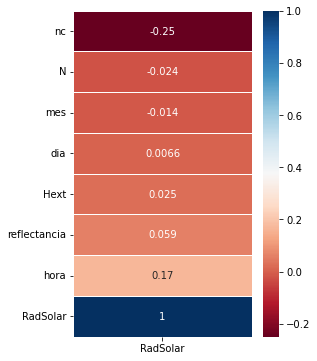

In [4]:
plt.figure(figsize=(4, 6))
if 'ann' in df3.columns: df3.drop(['Estacion', 'ann'], axis=1, inplace=True)
sns.heatmap(pd.DataFrame(df3.corr().RadSolar.sort_values()), annot=True, linewidth=0.5, cmap="RdBu");

**Matriz de correlación**

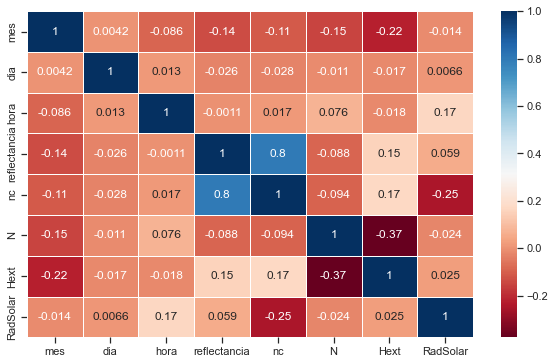

In [5]:
sns.set(style="ticks", color_codes=True)
plt.figure(figsize=(10, 6))
sns.heatmap(df3.corr(), linewidth=0.5, annot=True, cmap="RdBu"); #Colores degradados entre azul y vinotinto

**Modelo de Regresión**

**Preparando los datos para el análisis**

In [6]:
# n = 6500
# df3 = df3.sample(n)
print(df3.shape)

X = df3.drop(['RadSolar'], axis=1)
y = df3['RadSolar']

# Escalando las variables
scaler_X = RobustScaler()
scaler_y = RobustScaler()
X = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns)
y = scaler_y.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=100)

(14468, 8)


**Función para calcular el error porcentual absoluto medio**<br>
Es una medida estadística de lo exitoso que es un modelo predictivo. Mide el tamaño de los errores como un porcentaje. A medida que este valor se acerca a cero, el rendimiento aumenta.

In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100

**Función para graficar los resultados**

In [8]:
def plot(y_train, y_train_hat, y_test, y_test_hat):
    # Definimos los limites de la grafica
    plt.figure(figsize=(7,7))
    # fig, ax = plt.subplots()
    # ax.set(title=r'This is an expression $e^{\sin(\omega\phi)}$', xlabel='meters $10^1$', ylabel=r'Hertz $(\frac{1}{s})$')
    plt.axis([-100,1000,-100,1000])
    plt.plot([-100, 1000], [-100, 1000], "r--")
    #Grafica de dispersión (Real vs predicción)
    # plt.scatter(y_train, y_train_hat, label="Entrenamiento", alpha=0.8)
    # plt.scatter(y_test, y_test_hat, label="Pruebas", alpha=0.8)
    plt.scatter(scaler_y.inverse_transform(y_test.reshape(-1, 1)),
                scaler_y.inverse_transform(y_test_hat.reshape(-1, 1)))
    #Preparamos las etiquetas
    # plt.legend(prop={'size': 16})
    plt.title("M1. Locations with altitudes less than 800 masl", fontsize=18)
    # plt.xlabel("Radiación solar observada $(W/m^{2})$", fontsize=14)
    # plt.ylabel("Radiación solar estimada $(W/m^{2})$", fontsize=14)
    plt.xlabel("Measured Solar Radiation $(W/m^{2})$", fontsize=14)
    plt.ylabel("Estimated Solar Radiation $(W/m^{2})$", fontsize=14)
    #Calculamos error cuadrático medio
    error = mean_squared_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)),
                               scaler_y.inverse_transform(y_test_hat.reshape(-1, 1)))
    
    error_por_abs_medio = mean_absolute_percentage_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)),
                                                         scaler_y.inverse_transform(y_test_hat.reshape(-1, 1)))
    
    print('Media datos reales', np.mean(scaler_y.inverse_transform(y_test.reshape(-1, 1))))
    print('Media datos estimados', np.mean(scaler_y.inverse_transform(y_test_hat.reshape(-1, 1))))

    mbe = np.mean(scaler_y.inverse_transform(y_test_hat.reshape(-1, 1)) - scaler_y.inverse_transform(y_test.reshape(-1, 1)))

    rRMSE = (np.sqrt(error) / np.mean(scaler_y.inverse_transform(y_test.reshape(-1, 1)))) * 100

    print("\nMBE (Error de Sesgo Medio): {:.2f}".format(mbe))
    print("MSE (Error Cuadrático Medio): {:.2f}".format(error))
    print("RMSE: {:.2f}".format(np.sqrt(error)))
    print("rRMSE (Error Cuadrático Medio Relativo): {:.2f}".format(rRMSE))
    print("MAPE (Error Porcentual Absoluto Medio): {:.2f}".format(error_por_abs_medio))

**Random Forest**

Entrenamiento:  0.7387746487905227 11575
Prueba:  0.7286343416628188 2893
Media datos reales 347.0070169374352
Media datos estimados 348.47144200352835

MBE (Error de Sesgo Medio): 1.46
MSE (Error Cuadrático Medio): 16689.32
RMSE: 129.19
rRMSE (Error Cuadrático Medio Relativo): 37.23
MAPE (Error Porcentual Absoluto Medio): 55.99


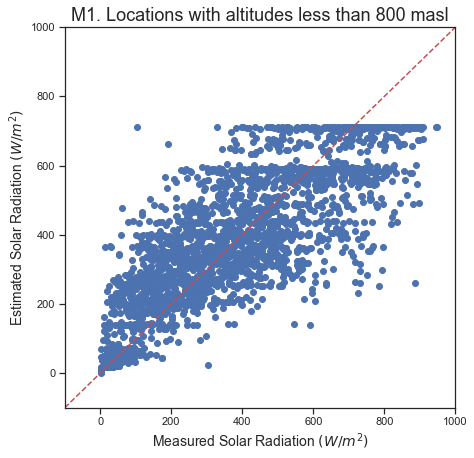

In [9]:
kf = KFold(n_splits=5, shuffle=True)

rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, max_depth=6)

resultados_y_train = []
resultados_y_test = []

for train_index, test_index in kf.split(X):
    X_train2, X_test2 = X.loc[train_index,], X.loc[test_index,]
    y_train2, y_test2 = y[train_index], y[test_index]
    rf.fit(X_train2, y_train2.ravel())
    y_train_hat2 = rf.predict(X_train2)
    y_test_hat2 = rf.predict(X_test2)
    # print("R2: ", r2_score(y_test2, y_test_hat2))
    # print("R2: ", r2_score(y_train2, y_train_hat2))
    resultados_y_test.append(r2_score(y_test2, y_test_hat2))
    resultados_y_train.append(r2_score(y_train2, y_train_hat2))

print("Entrenamiento: ", np.mean(resultados_y_train), np.size(y_train_hat2))
print("Prueba: ", np.mean(resultados_y_test), np.size(y_test_hat2))

plot(y_train2,y_train_hat2,y_test2,y_test_hat2)

**Random Forest. Ajuste de hiperparámetros con busqueda aleatoria**

[INFO] grid searching over the hyperparameters...
[INFO] evaluating...
R2: 0.94
R2 (Test): 0.81
RandomForestRegressor(bootstrap=False, max_depth=70, max_features='sqrt',
                      min_samples_split=15, n_estimators=140)
[INFO] grid search best parameters: {'n_estimators': 140, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}

Entrenamiento:  0.9382552748854676
Prueba:  0.8091684870984956
Media datos reales 348.97892190739464
Media datos estimados 353.49699503321347

MBE (Error de Sesgo Medio): 4.52
MSE (Error Cuadrático Medio): 12084.68
RMSE: 109.93
rRMSE (Error Cuadrático Medio Relativo): 31.50
MAPE (Error Porcentual Absoluto Medio): 46.84


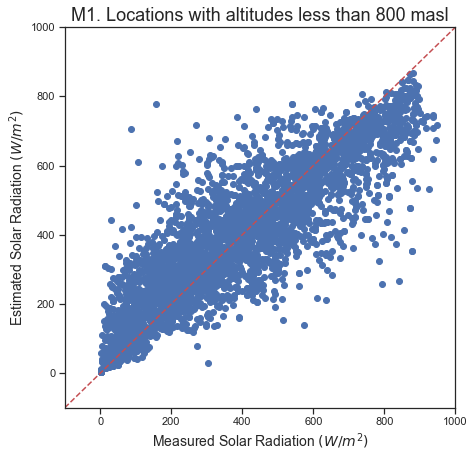

In [10]:
rf = RandomForestRegressor()

# Número de árboles en un bosque aleatorio
n_estimators = [int(x) for x in np.linspace(start=20, stop=200, num = 10)]
# Número de características a considerar en cada división
max_features = ['auto', 'sqrt']
# Número máximo de niveles en el árbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Número mínimo de muestras requeridas para dividir un nodo
min_samples_split = [2, 5, 10, 15, 20]
# Número mínimo de muestras requeridas en cada nodo hoja
min_samples_leaf = [1, 2, 4, 6]
# Método de selección de muestras para entrenar cada árbol 
bootstrap = [True, False]
grid = dict(n_estimators=n_estimators,
            max_features=max_features,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            bootstrap=bootstrap)

print("[INFO] grid searching over the hyperparameters...")
cvFold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
randomSearch = RandomizedSearchCV(estimator=rf,
                                  n_jobs=-1,
                                  cv=cvFold,
                                  param_distributions=grid,
                                  scoring="neg_mean_squared_error")
searchResults = randomSearch.fit(X_train, y_train.ravel())

# extract the best model and evaluate it
print("[INFO] evaluating...")
bestModel = searchResults.best_estimator_

print("R2: {:.2f}".format(bestModel.score(X_train, y_train)))
print("R2 (Test): {:.2f}".format(bestModel.score(X_test, y_test)))

print(bestModel)
print("[INFO] grid search best parameters: {}".format(searchResults.best_params_))

print("")

y_train_hat = bestModel.predict(X_train)
y_test_hat = bestModel.predict(X_test)
print("Entrenamiento: ", r2_score(y_train, y_train_hat))
print("Prueba: ", r2_score(y_test, y_test_hat))

plot(y_train, y_train_hat, y_test, y_test_hat)

#### Random Forest para Acueducto de Mocoa

In [11]:
df_acmocoa_2012 = pd.read_csv('data/DS-ACMocoa-2012.csv', sep=';')
df_acmocoa_2013 = pd.read_csv('data/DS-ACMocoa-2013.csv', sep=';')
df_acmocoa_2014 = pd.read_csv('data/DS-ACMocoa-2014.csv', sep=';')
df_acmocoa = pd.concat([df_acmocoa_2012, df_acmocoa_2013, df_acmocoa_2014], ignore_index=True, sort=False)
df_acmocoa.sort_values(by=['ann', 'mes', 'dia', 'hora'], inplace=True, ignore_index=True)
df_acmocoa = df_acmocoa[['mes', 'dia', 'hora', 'reflectancia', 'nc', 'N', 'Hext']]

df_acmocoa_final = df_acmocoa.copy()

X_acmocoa = pd.DataFrame(scaler_X.fit_transform(df_acmocoa_final), columns=df_acmocoa_final.columns)
y_acmocoa = bestModel.predict(X_acmocoa)

X_acmocoa_no_scaler = pd.DataFrame(scaler_X.inverse_transform(X_acmocoa))
y_acmocoa = pd.DataFrame(scaler_y.inverse_transform(y_acmocoa.reshape(-1, 1)))

df_acmocoa_final['RadSolar'] = y_acmocoa

print(df_acmocoa_final.shape)
df_acmocoa_final.head()

(5821, 8)


,mes,dia,hora,reflectancia,nc,N,Hext,RadSolar
0,1.0,1.0,7.0,0.2039,0.8429,11.9343,9809.5593,55.6166
1,1.0,1.0,10.0,0.1329,0.0569,11.9343,9809.5593,620.8693
2,1.0,1.0,13.0,0.2360,0.2167,11.9343,9809.5593,632.0554
3,1.0,1.0,16.0,0.0925,0.2550,11.9343,9809.5593,348.6380
4,1.0,2.0,6.0,0.0046,0.6570,11.9346,9816.0332,21.4642


#### Promedios de radiación solar mensual

In [16]:
df_pr_horario = df_acmocoa_final.copy()
df_pr_horario = df_pr_horario.drop(df_pr_horario[df_pr_horario['RadSolar'] < 0].index)

# Promedio horario de RadSolar
df_pr_horario = df_pr_horario[['mes', 'dia', 'hora', 'RadSolar']]
df_pr_horario = df_pr_horario.groupby(['mes', 'dia', 'hora'], as_index=False).mean()

df_pr_mensual = df_pr_horario.copy()
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 0].index)

# RadSolar diaria en kW/m2
df_pr_mensual = df_pr_mensual[['mes', 'dia', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes', 'dia'], as_index=False).sum()

df_pr_mensual[['mes']] = df_pr_mensual[['mes']].astype(int)
df_pr_mensual[['dia']] = df_pr_mensual[['dia']].astype(int)

# Eliminar registros con dias de menos de 3000 W/m2
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 3000].index)

df_pr_mensual.sort_values(by=['mes', 'dia'], inplace=True, ignore_index=True)
df_pr_mensual.to_csv('DS-Bosques-de-San-Joaquín-prom_mensuales.csv', sep=';', index=False, encoding='utf-8')

# Promedio mensual de RadSolar
df_pr_mensual = df_pr_mensual[['mes', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes'], as_index=False).mean()

# Convertir RadSolar de w/m2 a kW/m2
df_pr_mensual[['RadSolar']] = df_pr_mensual[['RadSolar']] / 1000

print(df_pr_mensual.shape)
df_pr_mensual.head(12)

(12, 2)


,mes,RadSolar
0,1,3.8810
1,2,4.1413
2,3,3.6262
3,4,3.7843
4,5,3.5277
5,6,3.3142
6,7,3.6139
7,8,3.8845
8,9,4.2339
9,10,4.5646


#### Random Forest para El Pepino (Mocoa)

In [13]:
df_elpepino_2012 = pd.read_csv('data/DS-El-Pepino-2012.csv', sep=';')
df_elpepino_2013 = pd.read_csv('data/DS-El-Pepino-2013.csv', sep=';')
df_elpepino_2014 = pd.read_csv('data/DS-El-Pepino-2014.csv', sep=';')
df_elpepino = pd.concat([df_elpepino_2012, df_elpepino_2013, df_elpepino_2014], ignore_index=True, sort=False)
df_elpepino.sort_values(by=['ann', 'mes', 'dia', 'hora'], inplace=True, ignore_index=True)
df_elpepino = df_elpepino[['mes', 'dia', 'hora', 'reflectancia', 'nc', 'N', 'Hext']]

df_elpepino_final = df_elpepino.copy()

X_elpepino = pd.DataFrame(scaler_X.fit_transform(df_elpepino_final), columns=df_elpepino_final.columns)
y_elpepino = bestModel.predict(X_elpepino)

X_elpepino_no_scaler = pd.DataFrame(scaler_X.inverse_transform(X_elpepino))
y_elpepino = pd.DataFrame(scaler_y.inverse_transform(y_elpepino.reshape(-1, 1)))

df_elpepino_final['RadSolar'] = y_elpepino

print(df_elpepino_final.shape)
df_elpepino_final.head()

(5821, 8)


,mes,dia,hora,reflectancia,nc,N,Hext,RadSolar
0,1.0,1.0,7.0,0.2086,0.6108,11.9385,9818.4050,94.8326
1,1.0,1.0,10.0,0.3060,0.2214,11.9385,9818.4050,487.1018
2,1.0,1.0,13.0,0.3350,0.2764,11.9385,9818.4050,557.3190
3,1.0,1.0,16.0,0.3377,0.5798,11.9385,9818.4050,278.7567
4,1.0,2.0,6.0,-0.0030,0.1270,11.9388,9824.8514,26.2607


#### Promedios de radiación solar mensual

In [14]:
df_pr_horario = df_elpepino_final.copy()
df_pr_horario = df_pr_horario.drop(df_pr_horario[df_pr_horario['RadSolar'] < 0].index)

# Promedio horario de RadSolar
df_pr_horario = df_pr_horario[['mes', 'dia', 'hora', 'RadSolar']]
df_pr_horario = df_pr_horario.groupby(['mes', 'dia', 'hora'], as_index=False).mean()

df_pr_mensual = df_pr_horario.copy()
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 0].index)

# RadSolar diaria en kW/m2
df_pr_mensual = df_pr_mensual[['mes', 'dia', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes', 'dia'], as_index=False).sum()

df_pr_mensual[['mes']] = df_pr_mensual[['mes']].astype(int)
df_pr_mensual[['dia']] = df_pr_mensual[['dia']].astype(int)

# Eliminar registros con dias de menos de 3000 W/m2
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 3000].index)

df_pr_mensual.sort_values(by=['mes', 'dia'], inplace=True, ignore_index=True)
df_pr_mensual.to_csv('DS-Bosques-de-San-Joaquín-prom_mensuales.csv', sep=';', index=False, encoding='utf-8')

# Promedio mensual de RadSolar
df_pr_mensual = df_pr_mensual[['mes', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes'], as_index=False).mean()

# Convertir RadSolar de w/m2 a kW/m2
df_pr_mensual[['RadSolar']] = df_pr_mensual[['RadSolar']] / 1000

print(df_pr_mensual.shape)
df_pr_mensual.head(12)

(12, 2)


,mes,RadSolar
0,1,4.0494
1,2,3.9857
2,3,3.6792
3,4,3.9001
4,5,3.5184
5,6,3.3716
6,7,3.6037
7,8,4.0739
8,9,4.2613
9,10,4.6224


#### Random Forest para Bosques de San Joaquín

In [51]:
df_bsj_2012 = pd.read_csv('data/DS-Bosques-de-San-Joaquín-2012.csv', sep=';')
df_bsj_2013 = pd.read_csv('data/DS-Bosques-de-San-Joaquín-2013.csv', sep=';')
df_bsj_2014 = pd.read_csv('data/DS-Bosques-de-San-Joaquín-2014.csv', sep=';')
df_bsj = pd.concat([df_bsj_2012, df_bsj_2013, df_bsj_2014], ignore_index=True, sort=False)
df_bsj.rename(columns = {'anno':'ann'}, inplace = True)
df_bsj.sort_values(by=['ann', 'mes', 'dia', 'hora'], inplace=True, ignore_index=True)
df_bsj = df_bsj[['mes', 'dia', 'hora', 'reflectancia', 'nc', 'N', 'Hext']]

# print(df_bsj.shape)
# df_bsj.head()

df_bsj_final = df_bsj.copy()

X_bsj = pd.DataFrame(scaler_X.fit_transform(df_bsj_final), columns=df_bsj_final.columns)
y_bsj = bestModel.predict(X_bsj)

X_bsj_no_scaler = pd.DataFrame(scaler_X.inverse_transform(X_bsj))
y_bsj = pd.DataFrame(scaler_y.inverse_transform(y_bsj.reshape(-1, 1)))

df_bsj_final['RadSolar'] = y_bsj

print(df_bsj_final.shape)
df_bsj_final.head()

(5821, 8)


,mes,dia,hora,reflectancia,nc,N,Hext,RadSolar
0,1.0,1.0,7.0,0.0832,0.2687,11.8083,9540.1638,23.0539
1,1.0,1.0,10.0,0.2474,0.1879,11.8083,9540.1638,450.3261
2,1.0,1.0,13.0,0.1321,0.1731,11.8083,9540.1638,570.3756
3,1.0,1.0,16.0,0.0543,0.1872,11.8083,9540.1638,237.2083
4,1.0,2.0,6.0,-0.0015,0.1949,11.8091,9547.4410,31.2083


#### Promedios de radiación solar mensual

In [33]:
df_pr_horario = df_bsj_final.copy()
df_pr_horario = df_pr_horario.drop(df_pr_horario[df_pr_horario['RadSolar'] < 0].index)

# Promedio horario de RadSolar
df_pr_horario = df_pr_horario[['mes', 'dia', 'hora', 'RadSolar']]
df_pr_horario = df_pr_horario.groupby(['mes', 'dia', 'hora'], as_index=False).mean()

# df_pr_horario.sort_values(by=['mes', 'dia', 'hora'], inplace=True, ignore_index=True)
# df_pr_horario.to_csv('DS-Bosques-de-San-Joaquín-prom_mensuales.csv', sep=';', index=False, encoding='utf-8')

# print(df_pr_horario.shape)
# df_pr_horario.head()

df_pr_mensual = df_pr_horario.copy()
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 0].index)
# df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['hora'] < 8].index)
# df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['hora'] > 16].index)

# RadSolar diaria en kW/m2
df_pr_mensual = df_pr_mensual[['mes', 'dia', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes', 'dia'], as_index=False).sum()

df_pr_mensual[['mes']] = df_pr_mensual[['mes']].astype(int)
df_pr_mensual[['dia']] = df_pr_mensual[['dia']].astype(int)

# Eliminar registros con dias de menos de 3000 W/m2
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 3000].index)

df_pr_mensual.sort_values(by=['mes', 'dia'], inplace=True, ignore_index=True)
df_pr_mensual.to_csv('DS-Bosques-de-San-Joaquín-prom_mensuales.csv', sep=';', index=False, encoding='utf-8')

# Promedio mensual de RadSolar
df_pr_mensual = df_pr_mensual[['mes', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes'], as_index=False).mean()

# Convertir RadSolar de w/m2 a kW/m2
df_pr_mensual[['RadSolar']] = df_pr_mensual[['RadSolar']] / 1000

print(df_pr_mensual.shape)
df_pr_mensual.head(12)

(12, 2)


,mes,RadSolar
0,1,3.9592
1,2,3.7061
2,3,3.4459
3,4,3.6685
4,5,3.8055
5,6,3.7959
6,7,3.7972
7,8,3.9801
8,9,4.4499
9,10,4.1943


#### Random Forest para Alto Peñol

In [31]:
df_alpe_2012 = pd.read_csv('data/DS-Alto-Peñol-2012-nc.csv', sep=';')
df_alpe_2013 = pd.read_csv('data/DS-Alto-Peñol-2013-nc.csv', sep=';')
df_alpe_2014 = pd.read_csv('data/DS-Alto-Peñol-2014-nc.csv', sep=';')
df_alpe = pd.concat([df_alpe_2012, df_alpe_2013, df_alpe_2014], ignore_index=True, sort=False)
df_alpe.rename(columns = {'anno':'ann'}, inplace = True)
df_alpe.sort_values(by=['ann', 'mes', 'dia', 'hora'], inplace=True, ignore_index=True)
df_alpe = df_alpe[['mes', 'dia', 'hora', 'reflectancia', 'nc', 'N', 'Hext']]

df_alpe_final = df_alpe.copy()

X_alpe = pd.DataFrame(scaler_X.fit_transform(df_alpe_final), columns=df_alpe_final.columns)
y_alpe = bestModel.predict(X_alpe)

X_alpe_no_scaler = pd.DataFrame(scaler_X.inverse_transform(X_alpe))
y_alpe = pd.DataFrame(scaler_y.inverse_transform(y_alpe.reshape(-1, 1)))

df_alpe_final['RadSolar'] = y_alpe

print(df_alpe_final.shape)
df_alpe_final.head()

(5821, 8)


,mes,dia,hora,reflectancia,nc,N,Hext,RadSolar
0,1.0,1.0,7.0,0.0123,0.0225,11.9168,9772.8624,27.1239
1,1.0,1.0,10.0,0.1150,0.0695,11.9168,9772.8624,586.6439
2,1.0,1.0,13.0,0.1325,0.0088,11.9168,9772.8624,758.8122
3,1.0,1.0,16.0,0.1085,0.2404,11.9168,9772.8624,268.5600
4,1.0,2.0,6.0,0.0030,0.7276,11.9172,9779.4496,14.6572


#### Promedios de radiación solar mensual

In [34]:
df_pr_horario = df_alpe_final.copy()
df_pr_horario = df_pr_horario.drop(df_pr_horario[df_pr_horario['RadSolar'] < 0].index)

# Promedio horario de RadSolar
df_pr_horario = df_pr_horario[['mes', 'dia', 'hora', 'RadSolar']]
df_pr_horario = df_pr_horario.groupby(['mes', 'dia', 'hora'], as_index=False).mean()

df_pr_mensual = df_pr_horario.copy()
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 0].index)

# RadSolar diaria en kW/m2
df_pr_mensual = df_pr_mensual[['mes', 'dia', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes', 'dia'], as_index=False).sum()

df_pr_mensual[['mes']] = df_pr_mensual[['mes']].astype(int)
df_pr_mensual[['dia']] = df_pr_mensual[['dia']].astype(int)

# Eliminar registros con dias de menos de 3000 W/m2
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 3000].index)

df_pr_mensual.sort_values(by=['mes', 'dia'], inplace=True, ignore_index=True)
df_pr_mensual.to_csv('DS-Alto-Peñol-prom_mensuales.csv', sep=';', index=False, encoding='utf-8')

# Promedio mensual de RadSolar
df_pr_mensual = df_pr_mensual[['mes', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes'], as_index=False).mean()

# Convertir RadSolar de w/m2 a kW/m2
df_pr_mensual[['RadSolar']] = df_pr_mensual[['RadSolar']] / 1000

print(df_pr_mensual.shape)
df_pr_mensual.head(12)

(12, 2)


,mes,RadSolar
0,1,3.8841
1,2,3.8129
2,3,3.4640
3,4,3.6771
4,5,3.7929
5,6,3.6059
6,7,3.5010
7,8,3.9079
8,9,4.1403
9,10,4.2387


#### Random Forest para Caimital

In [37]:
df_caimital_2012 = pd.read_csv('data/DS-Caimital-2012-nc.csv', sep=';')
df_caimital_2013 = pd.read_csv('data/DS-Caimital-2013-nc.csv', sep=';')
df_caimital_2014 = pd.read_csv('data/DS-Caimital-2014-nc.csv', sep=';')
df_caimital = pd.concat([df_caimital_2012, df_caimital_2013, df_caimital_2014], ignore_index=True, sort=False)
df_caimital.rename(columns = {'anno':'ann'}, inplace = True)
df_caimital.sort_values(by=['ann', 'mes', 'dia', 'hora'], inplace=True, ignore_index=True)
df_caimital = df_caimital[['mes', 'dia', 'hora', 'reflectancia', 'nc', 'N', 'Hext']]

df_caimital_final = df_caimital.copy()

X_caimital = pd.DataFrame(scaler_X.fit_transform(df_caimital_final), columns=df_caimital_final.columns)
y_caimital = bestModel.predict(X_caimital)

X_caimital_no_scaler = pd.DataFrame(scaler_X.inverse_transform(X_caimital))
y_caimital = pd.DataFrame(scaler_y.inverse_transform(y_caimital.reshape(-1, 1)))

df_caimital_final['RadSolar'] = y_caimital

print(df_caimital_final.shape)
df_caimital_final.head()

(5821, 8)


,mes,dia,hora,reflectancia,nc,N,Hext,RadSolar
0,1.0,1.0,7.0,0.0583,0.3023,11.3750,8546.0179,36.1089
1,1.0,1.0,10.0,0.0856,0.0164,11.3750,8546.0179,537.6189
2,1.0,1.0,13.0,0.1046,0.0113,11.3750,8546.0179,612.1667
3,1.0,1.0,16.0,0.0376,0.1595,11.3750,8546.0179,198.7828
4,1.0,2.0,6.0,0.0000,0.1059,11.3774,8555.7818,33.1533


#### Promedios de radiación solar mensual

In [38]:
df_pr_horario = df_caimital_final.copy()
df_pr_horario = df_pr_horario.drop(df_pr_horario[df_pr_horario['RadSolar'] < 0].index)

# Promedio horario de RadSolar
df_pr_horario = df_pr_horario[['mes', 'dia', 'hora', 'RadSolar']]
df_pr_horario = df_pr_horario.groupby(['mes', 'dia', 'hora'], as_index=False).mean()

df_pr_mensual = df_pr_horario.copy()
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 0].index)

# RadSolar diaria en kW/m2
df_pr_mensual = df_pr_mensual[['mes', 'dia', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes', 'dia'], as_index=False).sum()

df_pr_mensual[['mes']] = df_pr_mensual[['mes']].astype(int)
df_pr_mensual[['dia']] = df_pr_mensual[['dia']].astype(int)

# Eliminar registros con dias de menos de 3000 W/m2
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 3000].index)

df_pr_mensual.sort_values(by=['mes', 'dia'], inplace=True, ignore_index=True)
df_pr_mensual.to_csv('DS-Caimital-prom_mensuales.csv', sep=';', index=False, encoding='utf-8')

# Promedio mensual de RadSolar
df_pr_mensual = df_pr_mensual[['mes', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes'], as_index=False).mean()

# Convertir RadSolar de w/m2 a kW/m2
df_pr_mensual[['RadSolar']] = df_pr_mensual[['RadSolar']] / 1000

print(df_pr_mensual.shape)
df_pr_mensual.head(12)

(12, 2)


,mes,RadSolar
0,1,3.8071
1,2,4.0701
2,3,3.7220
3,4,3.7728
4,5,3.7939
5,6,3.7990
6,7,4.1283
7,8,3.5965
8,9,3.7301
9,10,3.8288


#### Random Forest para El Nilo

In [39]:
df_nilo_2012 = pd.read_csv('data/DS-El-Nilo-2012-nc.csv', sep=';')
df_nilo_2013 = pd.read_csv('data/DS-El-Nilo-2013-nc.csv', sep=';')
df_nilo_2014 = pd.read_csv('data/DS-El-Nilo-2014-nc.csv', sep=';')
df_nilo = pd.concat([df_nilo_2012, df_nilo_2013, df_nilo_2014], ignore_index=True, sort=False)
df_nilo.rename(columns = {'anno':'ann'}, inplace = True)
df_nilo.sort_values(by=['ann', 'mes', 'dia', 'hora'], inplace=True, ignore_index=True)
df_nilo = df_nilo[['mes', 'dia', 'hora', 'reflectancia', 'nc', 'N', 'Hext']]

df_nilo_final = df_nilo.copy()

X_nilo = pd.DataFrame(scaler_X.fit_transform(df_nilo_final), columns=df_nilo_final.columns)
y_nilo = bestModel.predict(X_nilo)

X_nilo_no_scaler = pd.DataFrame(scaler_X.inverse_transform(X_nilo))
y_nilo = pd.DataFrame(scaler_y.inverse_transform(y_nilo.reshape(-1, 1)))

df_nilo_final['RadSolar'] = y_nilo

print(df_nilo_final.shape)
df_nilo_final.head()

(5821, 8)


,mes,dia,hora,reflectancia,nc,N,Hext,RadSolar
0,1.0,1.0,7.0,0.1619,0.7643,11.8260,9578.6021,52.2656
1,1.0,1.0,10.0,0.0876,0.0181,11.8260,9578.6021,557.9656
2,1.0,1.0,13.0,0.8015,0.7055,11.8260,9578.6021,325.4678
3,1.0,1.0,16.0,0.3379,0.6307,11.8260,9578.6021,290.3689
4,1.0,2.0,6.0,0.0000,0.2629,11.8267,9585.7687,12.2294


#### Promedios de radiación solar mensual

In [40]:
df_pr_horario = df_nilo_final.copy()
df_pr_horario = df_pr_horario.drop(df_pr_horario[df_pr_horario['RadSolar'] < 0].index)

# Promedio horario de RadSolar
df_pr_horario = df_pr_horario[['mes', 'dia', 'hora', 'RadSolar']]
df_pr_horario = df_pr_horario.groupby(['mes', 'dia', 'hora'], as_index=False).mean()

df_pr_mensual = df_pr_horario.copy()
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 0].index)

# RadSolar diaria en kW/m2
df_pr_mensual = df_pr_mensual[['mes', 'dia', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes', 'dia'], as_index=False).sum()

df_pr_mensual[['mes']] = df_pr_mensual[['mes']].astype(int)
df_pr_mensual[['dia']] = df_pr_mensual[['dia']].astype(int)

# Eliminar registros con dias de menos de 3000 W/m2
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 3000].index)

df_pr_mensual.sort_values(by=['mes', 'dia'], inplace=True, ignore_index=True)
df_pr_mensual.to_csv('DS-El-Nilo-prom_mensuales.csv', sep=';', index=False, encoding='utf-8')

# Promedio mensual de RadSolar
df_pr_mensual = df_pr_mensual[['mes', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes'], as_index=False).mean()

# Convertir RadSolar de w/m2 a kW/m2
df_pr_mensual[['RadSolar']] = df_pr_mensual[['RadSolar']] / 1000

print(df_pr_mensual.shape)
df_pr_mensual.head(12)

(12, 2)


,mes,RadSolar
0,1,3.8711
1,2,3.7339
2,3,3.6178
3,4,3.7691
4,5,3.9038
5,6,3.8202
6,7,3.8025
7,8,3.8038
8,9,4.4317
9,10,4.3102


#### Random Forest para La Victoria

In [41]:
df_victoria_2012 = pd.read_csv('data/DS-La-Victoria-2012-nc.csv', sep=';')
df_victoria_2013 = pd.read_csv('data/DS-La-Victoria-2013-nc.csv', sep=';')
df_victoria_2014 = pd.read_csv('data/DS-La-Victoria-2014-nc.csv', sep=';')
df_victoria = pd.concat([df_victoria_2012, df_victoria_2013, df_victoria_2014], ignore_index=True, sort=False)
df_victoria.rename(columns = {'anno':'ann'}, inplace = True)
df_victoria.sort_values(by=['ann', 'mes', 'dia', 'hora'], inplace=True, ignore_index=True)
df_victoria = df_victoria[['mes', 'dia', 'hora', 'reflectancia', 'nc', 'N', 'Hext']]

df_victoria_final = df_victoria.copy()

X_victoria = pd.DataFrame(scaler_X.fit_transform(df_victoria_final), columns=df_victoria_final.columns)
y_victoria = bestModel.predict(X_victoria)

X_victoria_no_scaler = pd.DataFrame(scaler_X.inverse_transform(X_victoria))
y_victoria = pd.DataFrame(scaler_y.inverse_transform(y_victoria.reshape(-1, 1)))

df_victoria_final['RadSolar'] = y_victoria

print(df_victoria_final.shape)
df_victoria_final.head()

(5821, 8)


,mes,dia,hora,reflectancia,nc,N,Hext,RadSolar
0,1.0,1.0,7.0,0.0201,0.0523,11.8984,9734.0061,67.3333
1,1.0,1.0,10.0,0.0972,0.0257,11.8984,9734.0061,626.2933
2,1.0,1.0,13.0,0.1695,0.0639,11.8984,9734.0061,736.5372
3,1.0,1.0,16.0,0.0629,0.1661,11.8984,9734.0061,348.3100
4,1.0,2.0,6.0,-0.0030,0.1166,11.8988,9740.7119,26.8661


#### Promedios de radiación solar mensual

In [42]:
df_pr_horario = df_victoria_final.copy()
df_pr_horario = df_pr_horario.drop(df_pr_horario[df_pr_horario['RadSolar'] < 0].index)

# Promedio horario de RadSolar
df_pr_horario = df_pr_horario[['mes', 'dia', 'hora', 'RadSolar']]
df_pr_horario = df_pr_horario.groupby(['mes', 'dia', 'hora'], as_index=False).mean()

df_pr_mensual = df_pr_horario.copy()
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 0].index)

# RadSolar diaria en kW/m2
df_pr_mensual = df_pr_mensual[['mes', 'dia', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes', 'dia'], as_index=False).sum()

df_pr_mensual[['mes']] = df_pr_mensual[['mes']].astype(int)
df_pr_mensual[['dia']] = df_pr_mensual[['dia']].astype(int)

# Eliminar registros con dias de menos de 3000 W/m2
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 3000].index)

df_pr_mensual.sort_values(by=['mes', 'dia'], inplace=True, ignore_index=True)
df_pr_mensual.to_csv('DS-La-Victoria-prom_mensuales.csv', sep=';', index=False, encoding='utf-8')

# Promedio mensual de RadSolar
df_pr_mensual = df_pr_mensual[['mes', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes'], as_index=False).mean()

# Convertir RadSolar de w/m2 a kW/m2
df_pr_mensual[['RadSolar']] = df_pr_mensual[['RadSolar']] / 1000

print(df_pr_mensual.shape)
df_pr_mensual.head(12)

(12, 2)


,mes,RadSolar
0,1,3.8013
1,2,4.0557
2,3,3.6033
3,4,3.8176
4,5,3.7754
5,6,3.6311
6,7,3.8620
7,8,4.0354
8,9,4.2615
9,10,4.4002


#### Random Forest para Puerto Alegría

In [43]:
df_pto_alegria_2012 = pd.read_csv('data/DS-Puerto-Alegría-2012-nc.csv', sep=';')
df_pto_alegria_2013 = pd.read_csv('data/DS-Puerto-Alegría-2013-nc.csv', sep=';')
df_pto_alegria_2014 = pd.read_csv('data/DS-Puerto-Alegría-2014-nc.csv', sep=';')
df_pto_alegria = pd.concat([df_pto_alegria_2012, df_pto_alegria_2013, df_pto_alegria_2014], ignore_index=True, sort=False)
df_pto_alegria.rename(columns = {'anno':'ann'}, inplace = True)
df_pto_alegria.sort_values(by=['ann', 'mes', 'dia', 'hora'], inplace=True, ignore_index=True)
df_pto_alegria = df_pto_alegria[['mes', 'dia', 'hora', 'reflectancia', 'nc', 'N', 'Hext']]

df_pto_alegria_final = df_pto_alegria.copy()

X_pto_alegria = pd.DataFrame(scaler_X.fit_transform(df_pto_alegria_final), columns=df_pto_alegria_final.columns)
y_pto_alegria = bestModel.predict(X_pto_alegria)

X_pto_alegria_no_scaler = pd.DataFrame(scaler_X.inverse_transform(X_pto_alegria))
y_pto_alegria = pd.DataFrame(scaler_y.inverse_transform(y_pto_alegria.reshape(-1, 1)))

df_pto_alegria_final['RadSolar'] = y_pto_alegria

print(df_pto_alegria_final.shape)
df_pto_alegria_final.head()

(5821, 8)


,mes,dia,hora,reflectancia,nc,N,Hext,RadSolar
0,1.0,1.0,7.0,0.0845,0.2516,12.0306,10007.6747,56.2817
1,1.0,1.0,10.0,0.3209,0.2502,12.0306,10007.6747,482.1250
2,1.0,1.0,13.0,0.3904,0.2451,12.0306,10007.6747,526.5022
3,1.0,1.0,16.0,0.0855,0.2278,12.0306,10007.6747,382.1972
4,1.0,2.0,6.0,0.0441,0.3949,12.0304,10013.5142,24.9122


#### Promedios de radiación solar mensual

In [44]:
df_pr_horario = df_pto_alegria_final.copy()
df_pr_horario = df_pr_horario.drop(df_pr_horario[df_pr_horario['RadSolar'] < 0].index)

# Promedio horario de RadSolar
df_pr_horario = df_pr_horario[['mes', 'dia', 'hora', 'RadSolar']]
df_pr_horario = df_pr_horario.groupby(['mes', 'dia', 'hora'], as_index=False).mean()

df_pr_mensual = df_pr_horario.copy()
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 0].index)

# RadSolar diaria en kW/m2
df_pr_mensual = df_pr_mensual[['mes', 'dia', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes', 'dia'], as_index=False).sum()

df_pr_mensual[['mes']] = df_pr_mensual[['mes']].astype(int)
df_pr_mensual[['dia']] = df_pr_mensual[['dia']].astype(int)

# Eliminar registros con dias de menos de 3000 W/m2
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 3000].index)

df_pr_mensual.sort_values(by=['mes', 'dia'], inplace=True, ignore_index=True)
df_pr_mensual.to_csv('DS-Puerto-Alegría-prom_mensuales.csv', sep=';', index=False, encoding='utf-8')

# Promedio mensual de RadSolar
df_pr_mensual = df_pr_mensual[['mes', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes'], as_index=False).mean()

# Convertir RadSolar de w/m2 a kW/m2
df_pr_mensual[['RadSolar']] = df_pr_mensual[['RadSolar']] / 1000

print(df_pr_mensual.shape)
df_pr_mensual.head(12)

(12, 2)


,mes,RadSolar
0,1,3.9812
1,2,3.7848
2,3,4.0077
3,4,3.7248
4,5,3.6845
5,6,3.4198
6,7,3.3637
7,8,4.0631
8,9,4.2692
9,10,4.6107


#### Random Forest para el Resguardo Alto Lorenzo

In [47]:
df_res_alto_lor_2012 = pd.read_csv('data/DS-Resguardo-Alto-Lorenzo-2012-nc.csv', sep=';')
df_res_alto_lor_2013 = pd.read_csv('data/DS-Resguardo-Alto-Lorenzo-2013-nc.csv', sep=';')
df_res_alto_lor_2014 = pd.read_csv('data/DS-Resguardo-Alto-Lorenzo-2014-nc.csv', sep=';')
df_res_alto_lor = pd.concat([df_res_alto_lor_2012, df_res_alto_lor_2013, df_res_alto_lor_2014], ignore_index=True, sort=False)
df_res_alto_lor.rename(columns = {'anno':'ann'}, inplace = True)
df_res_alto_lor.sort_values(by=['ann', 'mes', 'dia', 'hora'], inplace=True, ignore_index=True)
df_res_alto_lor = df_res_alto_lor[['mes', 'dia', 'hora', 'reflectancia', 'nc', 'N', 'Hext']]

df_res_alto_lor_final = df_res_alto_lor.copy()

X_res_alto_lor = pd.DataFrame(scaler_X.fit_transform(df_res_alto_lor_final), columns=df_res_alto_lor_final.columns)
y_res_alto_lor = bestModel.predict(X_res_alto_lor)

X_res_alto_lor_no_scaler = pd.DataFrame(scaler_X.inverse_transform(X_res_alto_lor))
y_res_alto_lor = pd.DataFrame(scaler_y.inverse_transform(y_res_alto_lor.reshape(-1, 1)))

df_res_alto_lor_final['RadSolar'] = y_res_alto_lor

print(df_res_alto_lor_final.shape)
df_res_alto_lor_final.head()

(5821, 8)


,mes,dia,hora,reflectancia,nc,N,Hext,RadSolar
0,1.0,1.0,7.0,0.0155,0.0169,11.9793,9902.9890,88.9883
1,1.0,1.0,10.0,0.5838,0.0030,11.9793,9902.9890,539.4600
2,1.0,1.0,13.0,0.4048,0.2362,11.9793,9902.9890,565.0344
3,1.0,1.0,16.0,0.0464,0.1692,11.9793,9902.9890,307.1106
4,1.0,2.0,6.0,0.0015,0.4511,11.9794,9909.1686,24.3900


#### Promedios de radiación solar mensual

In [52]:
df_pr_horario = df_res_alto_lor_final.copy()
df_pr_horario = df_pr_horario.drop(df_pr_horario[df_pr_horario['RadSolar'] < 0].index)

# Promedio horario de RadSolar
df_pr_horario = df_pr_horario[['mes', 'dia', 'hora', 'RadSolar']]
df_pr_horario = df_pr_horario.groupby(['mes', 'dia', 'hora'], as_index=False).mean()

df_pr_mensual = df_pr_horario.copy()
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 0].index)

# RadSolar diaria en kW/m2
df_pr_mensual = df_pr_mensual[['mes', 'dia', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes', 'dia'], as_index=False).sum()

df_pr_mensual[['mes']] = df_pr_mensual[['mes']].astype(int)
df_pr_mensual[['dia']] = df_pr_mensual[['dia']].astype(int)

# Eliminar registros con dias de menos de 3000 W/m2
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 3000].index)

df_pr_mensual.sort_values(by=['mes', 'dia'], inplace=True, ignore_index=True)
df_pr_mensual.to_csv('DS-Resguardo-Alto-Lorenzo-prom_mensuales.csv', sep=';', index=False, encoding='utf-8')

# Promedio mensual de RadSolar
df_pr_mensual = df_pr_mensual[['mes', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes'], as_index=False).mean()

# Convertir RadSolar de w/m2 a kW/m2
df_pr_mensual[['RadSolar']] = df_pr_mensual[['RadSolar']] / 1000

print(df_pr_mensual.shape)
df_pr_mensual.head(12)

(12, 2)


,mes,RadSolar
0,1,3.9469
1,2,3.7464
2,3,3.6167
3,4,3.6970
4,5,3.4672
5,6,3.5031
6,7,3.4181
7,8,3.8969
8,9,4.2007
9,10,4.5834


#### Random Forest para el Resguardo Santa Rosa de Juanambú

In [53]:
df_res_sta_rosa_2012 = pd.read_csv('data/DS-Resguardo-Santa-Rosa-de-Juanambú-2012-nc.csv', sep=';')
df_res_sta_rosa_2013 = pd.read_csv('data/DS-Resguardo-Santa-Rosa-de-Juanambú-2013-nc.csv', sep=';')
df_res_sta_rosa_2014 = pd.read_csv('data/DS-Resguardo-Santa-Rosa-de-Juanambú-2014-nc.csv', sep=';')
df_res_sta_rosa = pd.concat([df_res_sta_rosa_2012, df_res_sta_rosa_2013, df_res_sta_rosa_2014], ignore_index=True, sort=False)
df_res_sta_rosa.rename(columns = {'anno':'ann'}, inplace = True)
df_res_sta_rosa.sort_values(by=['ann', 'mes', 'dia', 'hora'], inplace=True, ignore_index=True)
df_res_sta_rosa = df_res_sta_rosa[['mes', 'dia', 'hora', 'reflectancia', 'nc', 'N', 'Hext']]

df_res_sta_rosa_final = df_res_sta_rosa.copy()

X_res_sta_rosa = pd.DataFrame(scaler_X.fit_transform(df_res_sta_rosa_final), columns=df_res_sta_rosa_final.columns)
y_res_sta_rosa = bestModel.predict(X_res_sta_rosa)

X_res_sta_rosa_no_scaler = pd.DataFrame(scaler_X.inverse_transform(X_res_sta_rosa))
y_res_sta_rosa = pd.DataFrame(scaler_y.inverse_transform(y_res_sta_rosa.reshape(-1, 1)))

df_res_sta_rosa_final['RadSolar'] = y_res_sta_rosa

print(df_res_sta_rosa_final.shape)
df_res_sta_rosa_final.head()

(5821, 8)


,mes,dia,hora,reflectancia,nc,N,Hext,RadSolar
0,1.0,1.0,7.0,0.0216,0.0266,11.9586,9860.2110,107.7478
1,1.0,1.0,10.0,0.1736,0.1147,11.9586,9860.2110,513.2556
2,1.0,1.0,13.0,0.1232,0.1299,11.9586,9860.2110,586.2744
3,1.0,1.0,16.0,0.0395,0.1415,11.9586,9860.2110,380.4022
4,1.0,2.0,6.0,0.0030,0.5231,11.9588,9866.5264,23.9828


#### Promedios de radiación solar mensual

In [54]:
df_pr_horario = df_res_sta_rosa_final.copy()
df_pr_horario = df_pr_horario.drop(df_pr_horario[df_pr_horario['RadSolar'] < 0].index)

# Promedio horario de RadSolar
df_pr_horario = df_pr_horario[['mes', 'dia', 'hora', 'RadSolar']]
df_pr_horario = df_pr_horario.groupby(['mes', 'dia', 'hora'], as_index=False).mean()

df_pr_mensual = df_pr_horario.copy()
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 0].index)

# RadSolar diaria en kW/m2
df_pr_mensual = df_pr_mensual[['mes', 'dia', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes', 'dia'], as_index=False).sum()

df_pr_mensual[['mes']] = df_pr_mensual[['mes']].astype(int)
df_pr_mensual[['dia']] = df_pr_mensual[['dia']].astype(int)

# Eliminar registros con dias de menos de 3000 W/m2
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 3000].index)

df_pr_mensual.sort_values(by=['mes', 'dia'], inplace=True, ignore_index=True)
df_pr_mensual.to_csv('DS-Resguardo-Santa-Rosa-de-Juanambú-prom_mensuales.csv', sep=';', index=False, encoding='utf-8')

# Promedio mensual de RadSolar
df_pr_mensual = df_pr_mensual[['mes', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes'], as_index=False).mean()

# Convertir RadSolar de w/m2 a kW/m2
df_pr_mensual[['RadSolar']] = df_pr_mensual[['RadSolar']] / 1000

print(df_pr_mensual.shape)
df_pr_mensual.head(12)

(12, 2)


,mes,RadSolar
0,1,3.7635
1,2,3.7052
2,3,3.6236
3,4,3.8115
4,5,3.4961
5,6,3.6419
6,7,3.4954
7,8,3.8980
8,9,4.3570
9,10,4.6227


#### Random Forest para San José del Guineo

In [55]:
df_san_jose_2012 = pd.read_csv('data/DS-San-José-del-Guineo-2012-nc.csv', sep=';')
df_san_jose_2013 = pd.read_csv('data/DS-San-José-del-Guineo-2013-nc.csv', sep=';')
df_san_jose_2014 = pd.read_csv('data/DS-San-José-del-Guineo-2014-nc.csv', sep=';')
df_san_jose = pd.concat([df_san_jose_2012, df_san_jose_2013, df_san_jose_2014], ignore_index=True, sort=False)
df_san_jose.rename(columns = {'anno':'ann'}, inplace = True)
df_san_jose.sort_values(by=['ann', 'mes', 'dia', 'hora'], inplace=True, ignore_index=True)
df_san_jose = df_san_jose[['mes', 'dia', 'hora', 'reflectancia', 'nc', 'N', 'Hext']]

df_san_jose_final = df_san_jose.copy()

X_san_jose = pd.DataFrame(scaler_X.fit_transform(df_san_jose_final), columns=df_san_jose_final.columns)
y_san_jose = bestModel.predict(X_san_jose)

X_san_jose_no_scaler = pd.DataFrame(scaler_X.inverse_transform(X_san_jose))
y_san_jose = pd.DataFrame(scaler_y.inverse_transform(y_san_jose.reshape(-1, 1)))

df_san_jose_final['RadSolar'] = y_san_jose

print(df_san_jose_final.shape)
df_san_jose_final.head()

(5821, 8)


,mes,dia,hora,reflectancia,nc,N,Hext,RadSolar
0,1.0,1.0,7.0,0.1097,0.3198,11.9464,9834.7375,33.5389
1,1.0,1.0,10.0,0.0909,0.0358,11.9464,9834.7375,602.0872
2,1.0,1.0,13.0,0.2388,0.2200,11.9464,9834.7375,589.3806
3,1.0,1.0,16.0,0.2178,0.4360,11.9464,9834.7375,249.0239
4,1.0,2.0,6.0,0.0000,0.4321,11.9466,9841.1330,21.3567


#### Promedios de radiación solar mensual

In [56]:
df_pr_horario = df_san_jose_final.copy()
df_pr_horario = df_pr_horario.drop(df_pr_horario[df_pr_horario['RadSolar'] < 0].index)

# Promedio horario de RadSolar
df_pr_horario = df_pr_horario[['mes', 'dia', 'hora', 'RadSolar']]
df_pr_horario = df_pr_horario.groupby(['mes', 'dia', 'hora'], as_index=False).mean()

df_pr_mensual = df_pr_horario.copy()
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 0].index)

# RadSolar diaria en kW/m2
df_pr_mensual = df_pr_mensual[['mes', 'dia', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes', 'dia'], as_index=False).sum()

df_pr_mensual[['mes']] = df_pr_mensual[['mes']].astype(int)
df_pr_mensual[['dia']] = df_pr_mensual[['dia']].astype(int)

# Eliminar registros con dias de menos de 3000 W/m2
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 3000].index)

df_pr_mensual.sort_values(by=['mes', 'dia'], inplace=True, ignore_index=True)
df_pr_mensual.to_csv('DS-San-José-del-Guineo-prom_mensuales.csv', sep=';', index=False, encoding='utf-8')

# Promedio mensual de RadSolar
df_pr_mensual = df_pr_mensual[['mes', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes'], as_index=False).mean()

# Convertir RadSolar de w/m2 a kW/m2
df_pr_mensual[['RadSolar']] = df_pr_mensual[['RadSolar']] / 1000

print(df_pr_mensual.shape)
df_pr_mensual.head(12)

(12, 2)


,mes,RadSolar
0,1,3.9968
1,2,3.5970
2,3,3.8468
3,4,3.8340
4,5,3.5516
5,6,3.4878
6,7,3.4450
7,8,3.9098
8,9,4.1787
9,10,4.5782


#### Random Forest para San Luis del Plan

In [57]:
df_san_luis_2012 = pd.read_csv('data/DS-San-Luis-del-Plan-2012-nc.csv', sep=';')
df_san_luis_2013 = pd.read_csv('data/DS-San-Luis-del-Plan-2013-nc.csv', sep=';')
df_san_luis_2014 = pd.read_csv('data/DS-San-Luis-del-Plan-2014-nc.csv', sep=';')
df_san_luis = pd.concat([df_san_luis_2012, df_san_luis_2013, df_san_luis_2014], ignore_index=True, sort=False)
df_san_luis.rename(columns = {'anno':'ann'}, inplace = True)
df_san_luis.sort_values(by=['ann', 'mes', 'dia', 'hora'], inplace=True, ignore_index=True)
df_san_luis = df_san_luis[['mes', 'dia', 'hora', 'reflectancia', 'nc', 'N', 'Hext']]

df_san_luis_final = df_san_luis.copy()

X_san_luis = pd.DataFrame(scaler_X.fit_transform(df_san_luis_final), columns=df_san_luis_final.columns)
y_san_luis = bestModel.predict(X_san_luis)

X_san_luis_no_scaler = pd.DataFrame(scaler_X.inverse_transform(X_san_luis))
y_san_luis = pd.DataFrame(scaler_y.inverse_transform(y_san_luis.reshape(-1, 1)))

df_san_luis_final['RadSolar'] = y_san_luis

print(df_san_luis_final.shape)
df_san_luis_final.head()

(5821, 8)


,mes,dia,hora,reflectancia,nc,N,Hext,RadSolar
0,1.0,1.0,7.0,0.0155,0.0163,11.7457,9402.3999,78.5039
1,1.0,1.0,10.0,0.0823,0.0154,11.7457,9402.3999,494.7206
2,1.0,1.0,13.0,0.1222,0.0033,11.7457,9402.3999,584.3083
3,1.0,1.0,16.0,0.1727,0.4365,11.7457,9402.3999,294.2794
4,1.0,2.0,6.0,0.0015,0.0501,11.7467,9410.0642,73.0944


#### Promedios de radiación solar mensual

In [58]:
df_pr_horario = df_san_luis_final.copy()
df_pr_horario = df_pr_horario.drop(df_pr_horario[df_pr_horario['RadSolar'] < 0].index)

# Promedio horario de RadSolar
df_pr_horario = df_pr_horario[['mes', 'dia', 'hora', 'RadSolar']]
df_pr_horario = df_pr_horario.groupby(['mes', 'dia', 'hora'], as_index=False).mean()

df_pr_mensual = df_pr_horario.copy()
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 0].index)

# RadSolar diaria en kW/m2
df_pr_mensual = df_pr_mensual[['mes', 'dia', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes', 'dia'], as_index=False).sum()

df_pr_mensual[['mes']] = df_pr_mensual[['mes']].astype(int)
df_pr_mensual[['dia']] = df_pr_mensual[['dia']].astype(int)

# Eliminar registros con dias de menos de 3000 W/m2
df_pr_mensual = df_pr_mensual.drop(df_pr_mensual[df_pr_mensual['RadSolar'] < 3000].index)

df_pr_mensual.sort_values(by=['mes', 'dia'], inplace=True, ignore_index=True)
df_pr_mensual.to_csv('DS-San-Luis-del-Plan-prom_mensuales.csv', sep=';', index=False, encoding='utf-8')

# Promedio mensual de RadSolar
df_pr_mensual = df_pr_mensual[['mes', 'RadSolar']]
df_pr_mensual = df_pr_mensual.groupby(['mes'], as_index=False).mean()

# Convertir RadSolar de w/m2 a kW/m2
df_pr_mensual[['RadSolar']] = df_pr_mensual[['RadSolar']] / 1000

print(df_pr_mensual.shape)
df_pr_mensual.head(12)

(12, 2)


,mes,RadSolar
0,1,3.7213
1,2,4.4227
2,3,3.6307
3,4,4.0312
4,5,3.9382
5,6,3.8122
6,7,3.8333
7,8,4.0171
8,9,4.2459
9,10,4.4279
